<a href="https://www.kaggle.com/odins0n/fake-or-not-fake?scriptVersionId=83226462" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

**Created by Sanskar Hasija**

**Fake or Not Fake🤔**

**1 NOVEMBER 2021**


# <center> FAKE OR NOTE FAKE🤔</center>
## <center>If you find this notebook useful, support with an upvote👍</center>

## [1. Imports](#im) ##
## [2. HyperParameters](#hp) ##
## [3. Data Loading and Preprocessing](#data) ##
## [4. DenseNet201 Model](#model)  ##
## [5. Training](#train) ##

<a id="im"></a>
# <center>IMPORTING LIBRARIES</center> 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix , classification_report , roc_auc_score , roc_curve


from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

<a id="hp"></a>
# <center>HYPERPARAMETRERS AND DIRECTORIES</center>

In [2]:
input_dir = "../input/fake-video-images-dataset/images_from_video_big/"

SEED = 12
IMG_HEIGHT= 160
IMG_WIDTH = 160
BATCH_SIZE = 32
EPOCHS = 30
SEED = 12 
EARLY_STOPPING_CRITERIA =  5
EPOCHS = 30
LR = 0.0005
CLASS_LABELS = ["NOT FAKE" , "FAKE"]

<a id="data"></a>
# <center> DATA LOADING AND PRE-PROCESSING</center>

### Creating a dataframe containing filename and labels

In [3]:
data = []
for img in os.listdir("../input/fake-video-images-dataset/images_from_video_big") :
    img_dir = input_dir + img
    data.append(img_dir)
    
image_df = pd.DataFrame(data , columns= ["filename"])
image_df["class"] = 1 
for i in range(len(image_df)):
    if image_df["filename"][i][-5] == str(0):
        image_df["class"][i] = 0
image_df["class"] = image_df["class"].astype("str")

offset = int(len(image_df) * 0.70)
train = image_df[:offset]
test = image_df[offset:]

In [4]:
preprocess_fun = tf.keras.applications.densenet.preprocess_input
train_datagen = ImageDataGenerator(horizontal_flip=True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   rescale = 1./255,
                                   validation_split = 0.3,
                                   preprocessing_function=preprocess_fun
                                  )
test_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.3,
                                  preprocessing_function=preprocess_fun)

In [5]:
train_generator = train_datagen.flow_from_dataframe(dataframe = train, 
                                                    x_col= 'filename', 
                                                    y_col='class',
                                                    target_size=(IMG_HEIGHT , IMG_WIDTH), 
                                                    color_mode='rgb', class_mode='binary', 
                                                    batch_size=BATCH_SIZE,
                                                    subset = "training",
                                                    shuffle=True,
                                                    seed=SEED)

test_generator = test_datagen.flow_from_dataframe(dataframe = test, 
                                                        x_col='filename', 
                                                        y_col='class',
                                                        target_size=(IMG_HEIGHT , IMG_WIDTH), 
                                                        color_mode='rgb', class_mode='binary', 
                                                        batch_size=BATCH_SIZE, 
                                                        subset = "validation",
                                                        shuffle=False,
                                                        seed=SEED)

Found 40484 validated image filenames belonging to 2 classes.
Found 7436 validated image filenames belonging to 2 classes.


## Images of both classes

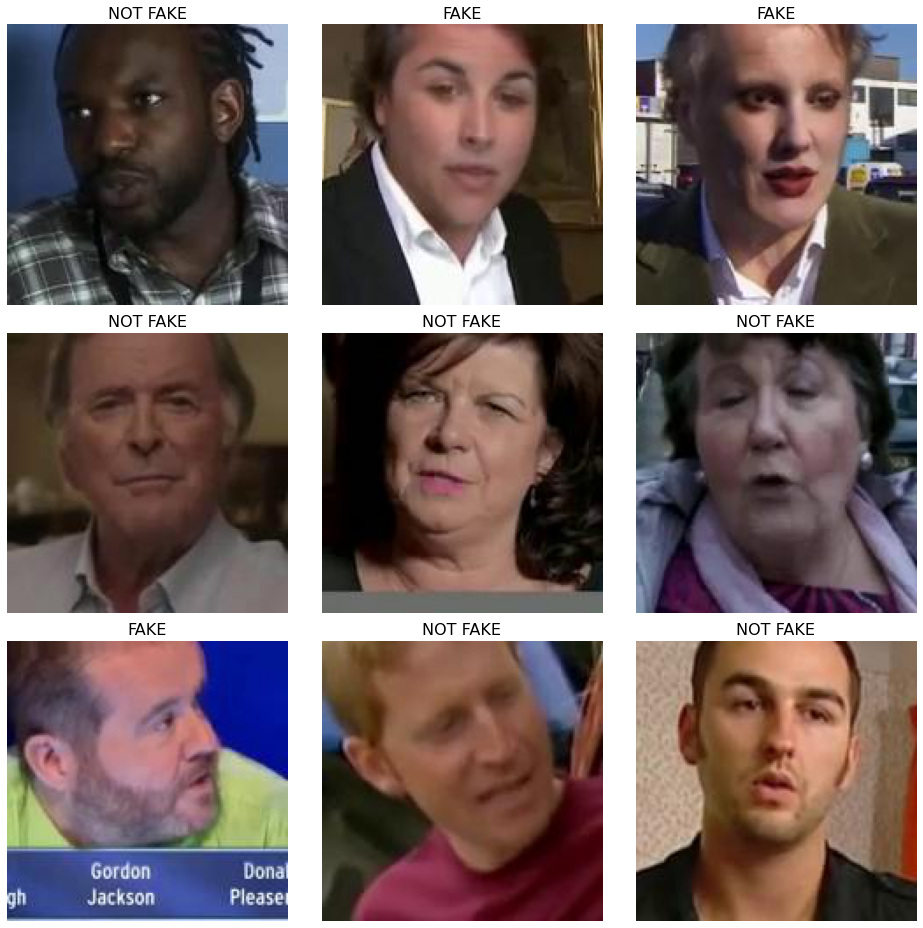

In [6]:
def display_one_image(image, title, subplot, color):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=16)
    
def display_nine_images(images, titles, title_colors=None):
    subplot = 331
    plt.figure(figsize=(13,13))
    for i in range(9):
        color = 'black' if title_colors is None else title_colors[i]
        display_one_image(images[i], titles[i], 331+i, color)
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()
clear_output()

temp_datagen = ImageDataGenerator(rescale = 1./255)
temp_generator = temp_datagen.flow_from_dataframe(dataframe = test[:100], 
                                                        x_col='filename', 
                                                        y_col='class',
                                                        target_size=(IMG_HEIGHT , IMG_WIDTH), 
                                                        color_mode='rgb', class_mode='binary', 
                                                        batch_size=BATCH_SIZE, 
                                                        shuffle=True,
                                                        seed=SEED)
clear_output()
images, classes = next(temp_generator)
classes = classes.astype("int") 
labels = [CLASS_LABELS[idx] for idx in classes]
display_nine_images(images, labels)

## Data distribution (count) among both classes

In [7]:
fig = px.bar(x = CLASS_LABELS,
             y = [list(train_generator.classes).count(i) for i in np.unique(train_generator.classes)] , 
             color = np.unique(train_generator.classes) ,
             color_continuous_scale="Emrld") 
fig.update_xaxes(title="Images")
fig.update_yaxes(title = "Number of Images")
fig.update_layout(showlegend = True,
    title = {
        'text': 'Train Data Distribution ',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

<a id="model"></a>
# <center> DenseNet201 Transfer Learning  </center>

In [8]:
def feature_extractor(inputs):
    feature_extractor = tf.keras.applications.DenseNet201(input_shape=(IMG_HEIGHT,IMG_WIDTH, 3),
                                               include_top=False,
                                               weights="imagenet")(inputs)
    
    return feature_extractor

def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Dense(256, activation="relu", kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(1024, activation="relu", kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.7)(x)
    x = tf.keras.layers.Dense(512, activation="relu", kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.6) (x)
    x = tf.keras.layers.Dense(1, activation="sigmoid", name="classification")(x)
    
    return x

def final_model(inputs):
    densenet_feature_extractor = feature_extractor(inputs)
    classification_output = classifier(densenet_feature_extractor)
    
    return classification_output

def define_compile_model():
    
    inputs = tf.keras.layers.Input(shape=(IMG_HEIGHT ,IMG_WIDTH,3))
    classification_output = final_model(inputs) 
    model = tf.keras.Model(inputs=inputs, outputs = classification_output)
     
    model.compile(optimizer=tf.keras.optimizers.SGD(0.1), 
                loss='binary_crossentropy',
                metrics = ["accuracy",tf.keras.metrics.AUC()])
  
    return model

## Summary of model

In [9]:
model = define_compile_model()
clear_output()

# Feezing the feature extraction layers
model.layers[1].trainable = False

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
densenet201 (Functional)     (None, 5, 5, 1920)        18321984  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1920)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               491776    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              263168    
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0     

<a id="train"></a>
# <center> Training </center> 

## Training model with freezed layers of DenseNet201

In [10]:
earlyStoppingCallback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                         patience=EARLY_STOPPING_CRITERIA,
                                                         verbose= 1 ,
                                                         restore_best_weights=True
                                                        )

history = model.fit(x = train_generator,
                    epochs = EPOCHS,
                    validation_data = test_generator , 
                    callbacks= [earlyStoppingCallback])

history = pd.DataFrame(history.history)

2021-12-24 17:43:14.158061: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2021-12-24 17:43:34.079963: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


1266/1266 [==============================] - 517s 387ms/step - loss: 3.5315 - accuracy: 0.7705 - auc: 0.8262 - val_loss: 0.7645 - val_accuracy: 0.7712 - val_auc: 0.8870
Epoch 2/30
1266/1266 [==============================] - 437s 345ms/step - loss: 0.4050 - accuracy: 0.8407 - auc: 0.9037 - val_loss: 0.3770 - val_accuracy: 0.8470 - val_auc: 0.9235
Epoch 3/30
1266/1266 [==============================] - 442s 349ms/step - loss: 0.3429 - accuracy: 0.8647 - auc: 0.9256 - val_loss: 0.3933 - val_accuracy: 0.8435 - val_auc: 0.9294
Epoch 4/30
1266/1266 [==============================] - 435s 343ms/step - loss: 0.3100 - accuracy: 0.8805 - auc: 0.9394 - val_loss: 0.3552 - val_accuracy: 0.8720 - val_auc: 0.9369
Epoch 5/30
1266/1266 [==============================] - 435s 343ms/step - loss: 0.2871 - accuracy: 0.8900 - auc: 0.9483 - val_loss: 0.3340 - val_accuracy: 0.8653 - val_auc: 0.9343
Epoch 6/30
1266/1266 [==============================] - 460s 363ms/step - loss: 0.2750 - accuracy: 0.8989 - auc

## Training plots

In [11]:
x = px.line(data_frame= history , y= ["accuracy" , "val_accuracy"] ,markers = True )
x.update_xaxes(title="Number of Epochs")
x.update_yaxes(title = "Accuracy")
x.update_layout(showlegend = True,
    title = {
        'text': 'Accuracy vs Number of Epochs',
        'y':0.94,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
x.show()

In [12]:
x = px.line(data_frame= history , y= ["auc" , "val_auc"] , markers = True )
x.update_xaxes(title="Number of Epochs")
x.update_yaxes(title = "AUC Score")
x.update_layout(showlegend = True,
    title = {
        'text': 'AUC Score vs Number of Epochs',
        'y':0.94,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
x.show()

In [13]:
x = px.line(data_frame= history , y= ["loss" , "val_loss"] , markers = True )
x.update_xaxes(title="Number of Epochs")
x.update_yaxes(title = "Loss")
x.update_layout(showlegend = True,
    title = {
        'text': 'Loss vs Number of Epochs',
        'y':0.94,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
x.show()

# Evaluation

### Loss , Accuracy and AUC score on Test Data

In [14]:
model.evaluate(test_generator)
preds = model.predict(test_generator)
y_preds = (np.squeeze(preds) > 0.5).astype(int)
y_test = np.array(test_generator.labels)

233/233 [==============================] - 20s 86ms/step - loss: 0.2418 - accuracy: 0.9129 - auc: 0.9628


## Confusion Matrix

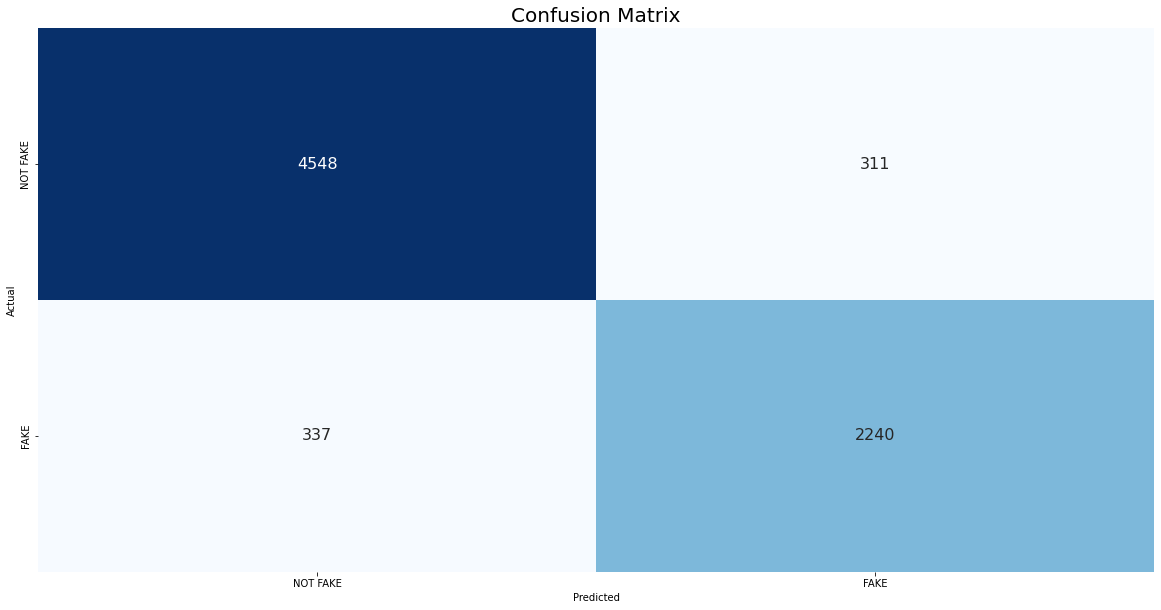

In [15]:
cm_data = confusion_matrix(y_test , y_preds)
cm = pd.DataFrame(cm_data, columns=CLASS_LABELS, index = CLASS_LABELS)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (20,10))
plt.title('Confusion Matrix', fontsize = 20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')

## Classification Report 

In [16]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.93      0.94      0.93      4859
           1       0.88      0.87      0.87      2577

    accuracy                           0.91      7436
   macro avg       0.90      0.90      0.90      7436
weighted avg       0.91      0.91      0.91      7436



## ROC AUC Score

In [17]:
print("ROC-AUC Score  = " ,roc_auc_score(y_test , preds))

ROC-AUC Score  =  0.963087990928986


## ROC AUC Curve

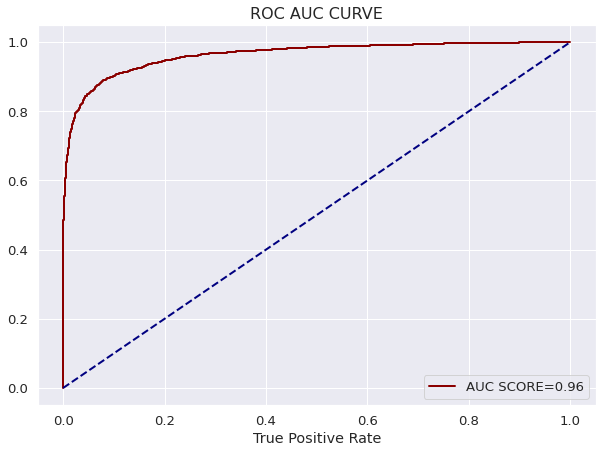

In [18]:
fpr, tpr, thresholds  = roc_curve(y_test, preds)
auc = roc_auc_score(y_test, preds)
plt.figure(figsize = (10,7))
plt.plot(fpr,tpr,color='darkred', lw=2, label="AUC SCORE="+str(round(auc,2)))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title('ROC AUC CURVE', fontsize = 16)
plt.xlabel("False Positive Rate")
plt.xlabel("True Positive Rate")
plt.legend(loc=4)
plt.show()